<div style="border: 2px solid #2196F3; border-radius: 8px; padding: 15px; background-color: rgba(33, 150, 243, 0.3); color: white;">
    <h3 style="color: white;">OBJECTIF</h3>
    <p>
        PRÉDIRE SI UNE TUMEUR EST MALIGNE OU BÉNIGNE À PARTIR DE MESURES CLINIQUES
    </p>
</div>

# Setup

In [1]:
#%pip install -r ../requirements.txt

In [2]:
# Manipulation et visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Préparation des données
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Modèles de classification utilisés
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Évaluation des modèles
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer

# Sauvegarde éventuelle du modèle
import pickle

In [3]:
# Import du dataset
df = pd.read_csv("../data/raw/data.csv")

In [4]:
# Fonction de bruit 
def add_noise(df, noise_level, random_state=42):
    """
    Injecte des NaN dans un pourcentage donné de cellules numériques du DataFrame.

    Parameters:
    - df : DataFrame original
    - noise_level : proportion de cellules numériques à rendre NaN 
    - random_state : pour la reproductibilité

    Returns:
    - DataFrame avec NaN injectés
    """
    np.random.seed(random_state)
    df_nan = df.copy()

    num_cols = df_nan.select_dtypes(include=[np.number]).columns
    n_rows = df_nan.shape[0]
    total_numeric_values = n_rows * len(num_cols)
    n_nan = int(total_numeric_values * noise_level)

    for _ in range(n_nan):
        i = np.random.randint(0, n_rows)
        j = np.random.choice(num_cols)
        df_nan.at[i, j] = np.nan

    return df_nan

In [5]:
df_noisy = add_noise(df, noise_level=0.05)  

In [6]:
df_noisy.isnull().sum() 

id                          32
diagnosis                    0
radius_mean                 31
texture_mean                35
perimeter_mean              26
area_mean                   34
smoothness_mean             27
compactness_mean            26
concavity_mean              22
concave points_mean         26
symmetry_mean               17
fractal_dimension_mean      17
radius_se                   30
texture_se                  28
perimeter_se                21
area_se                     30
smoothness_se               22
compactness_se              27
concavity_se                21
concave points_se           35
symmetry_se                 24
fractal_dimension_se        26
radius_worst                25
texture_worst               32
perimeter_worst             28
area_worst                  29
smoothness_worst            36
compactness_worst           29
concavity_worst             29
concave points_worst        29
symmetry_worst              33
fractal_dimension_worst     27
Unnamed:

In [7]:
df_noisy.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [8]:
# Encodage de la variable cible 
df_noisy['diagnosis'] = df_noisy['diagnosis'].map({'M': 1, 'B': 0})

In [9]:
df_noisy.drop(columns=["id", "Unnamed: 32"], inplace=True, errors='ignore')

# EDA

In [10]:
import dtale
dtale.show(df_noisy)

In [11]:
# Distribution de la cible’
df_noisy["diagnosis"].value_counts(normalize=True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

<div style="border: 1px solid #888888; border-radius: 5px; padding: 8px 12px; background-color: rgba(200, 200, 200, 0.15); color: white; display: inline-block; font-size: 90%;">
    <strong>Remarque</strong> : le dataset reste relativement équilibré pour une tâche de classification.
</div>


In [12]:
# Affichage des colonnes fortement corrélées (>0.9)
corr_matrix = df_noisy.drop(columns="diagnosis").corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_vars = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
print(high_corr_vars)


['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


<div style="border: 1px solid #888888; border-radius: 5px; padding: 8px 12px; background-color: rgba(200, 200, 200, 0.15); color: white; display: inline-block; font-size: 90%;">
    <strong>Remarque</strong> : ces 10 variables devront éventuellement être enlevées en fonction du modèle que l'on va utiliser.
</div>


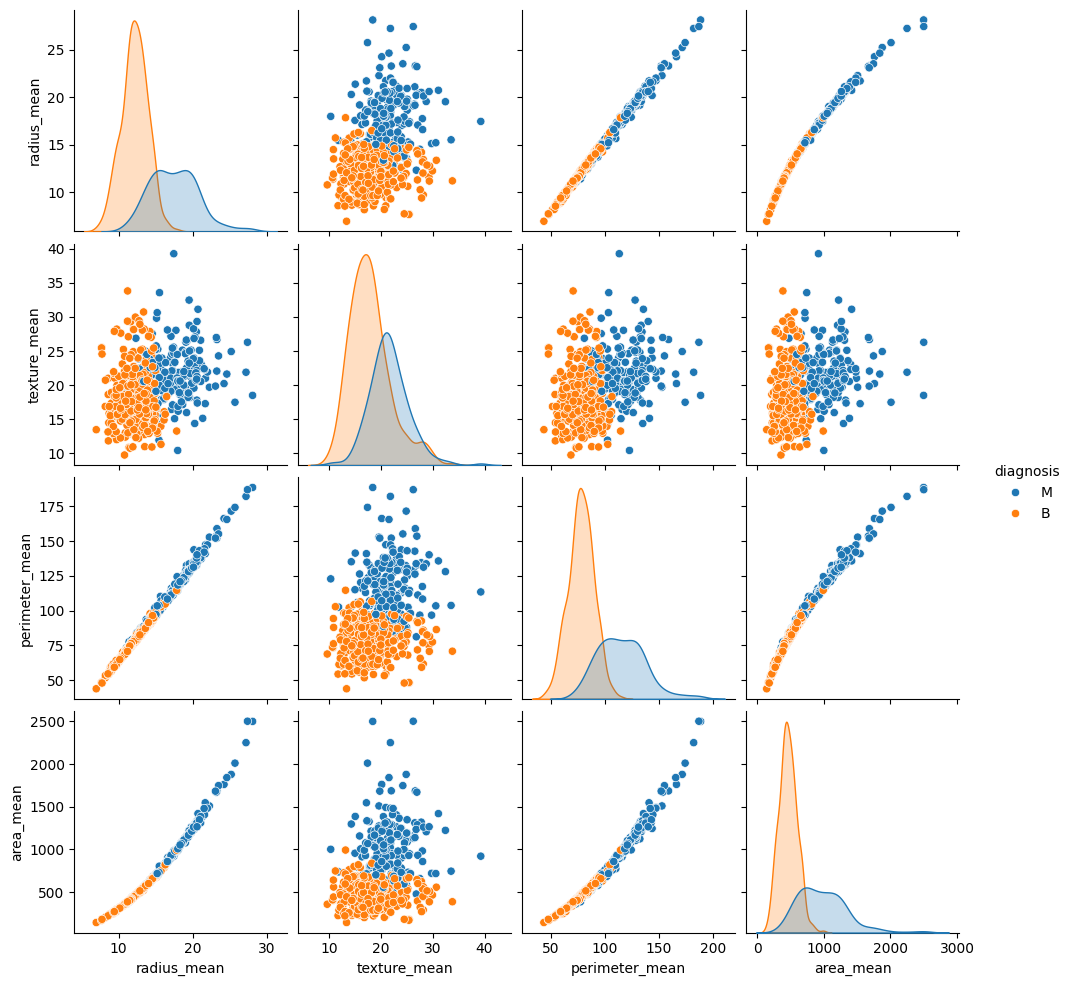

In [13]:
sns.pairplot(df[["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "diagnosis"]], hue="diagnosis")

<div style="border: 1px solid #888888; border-radius: 5px; padding: 8px 12px; background-color: rgba(200, 200, 200, 0.15); color: white; display: inline-block; font-size: 90%;">
    <strong>Remarque</strong> : le pairplot met en évidence une nette séparation entre les tumeurs bénignes et malignes sur plusieurs variables clés, notamment <code>radius_mean</code>, <code>perimeter_mean</code> et <code>area_mean</code>, où les observations malignes présentent systématiquement des valeurs plus élevées. À l’inverse, la variable <code>texture_mean</code> semble moins discriminante visuellement, avec une distribution plus homogène entre les deux classes.
</div>


# Data Préparation

In [14]:
# Suppression des lignes contenant des NaN (après ajout de bruit manquant)
df_noisy = df_noisy.dropna()

In [15]:
X = df_noisy.drop(columns=["diagnosis"]) 
y = df_noisy["diagnosis"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<div style="border: 1px solid #888888; border-radius: 5px; padding: 8px 12px; background-color: rgba(200, 200, 200, 0.15); color: white; display: inline-block; font-size: 90%;">
    <strong>Remarque</strong> : on standardise les données car <code>SVM</code> et la régression logistique sont sensibles à l’échelle des variables.
</div>


# Modélisation

In [18]:
# Gestion des colonnes à exclure pour la régression logistique
cols_to_drop = ['perimeter_mean', 'area_mean', 'concave points_mean',
                'perimeter_se', 'area_se', 'radius_worst', 'texture_worst',
                'perimeter_worst', 'area_worst', 'concave points_worst']

X_train_log = X_train.drop(columns=cols_to_drop)
X_test_log = X_test.drop(columns=cols_to_drop)

In [19]:
# Configuration des modèles
model_configs = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=10000, solver='saga'),
        "params": {
            "C": [0.1, 1, 10],
            "solver": ["saga"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 5, 10]
        }
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale"]
        }
    }
}

In [20]:
f1_custom = make_scorer(f1_score, pos_label=1)

In [21]:
# Entraînement, GridSearchCV et évaluation
results = []

for name, config in model_configs.items():
    print(f"\n===== Modèle : {name} =====")
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=5,
        scoring=f1_custom,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred))
    print("\nRapport de classification :")
    print(classification_report(y_test, y_pred, digits=3))

    results.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred), 3),
        "Recall": round(recall_score(y_test, y_pred), 3),
        "F1 Score": round(f1_score(y_test, y_pred), 3)
    })


===== Modèle : Logistic Regression =====
Matrice de confusion :
[[17  1]
 [ 1  9]]

Rapport de classification :
              precision    recall  f1-score   support

           0      0.944     0.944     0.944        18
           1      0.900     0.900     0.900        10

    accuracy                          0.929        28
   macro avg      0.922     0.922     0.922        28
weighted avg      0.929     0.929     0.929        28


===== Modèle : Random Forest =====
Matrice de confusion :
[[18  0]
 [ 0 10]]

Rapport de classification :
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        18
           1      1.000     1.000     1.000        10

    accuracy                          1.000        28
   macro avg      1.000     1.000     1.000        28
weighted avg      1.000     1.000     1.000        28


===== Modèle : SVM =====
Matrice de confusion :
[[17  1]
 [ 0 10]]

Rapport de classification :
              precision    re

In [22]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1 Score", ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
1,Random Forest,1.000,1.000,1.0,1.000
2,SVM,0.964,0.909,1.0,0.952
0,Logistic Regression,0.929,0.900,0.9,0.900
